In [1]:
from utils import set_root, PhysioLoader
import math

set_root()
%cd ..

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Current working directory: /home/manni/physioex
/home/manni


/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%ls

dreem/           miniconda3/  models/    plot.png      plots/
lightning_logs/  mne_data/    physioex/  plot_out.png  temp/


## Plotting Signals

In [3]:
# importing
from utils import PhysioLoader
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [4]:
models = ["seqsleepnet_cem"]
dataset = {"name": "sleep_physionet", "version": "2018"}
seqlen = 1
loss = "cel"
batch_size = 32

sleep_stages = ["Awake", "N1", "N2", "N3", "REM"]
if dataset["name"] == "mitdb":
    sleep_stages = ["N", "S", "V", "F", "Q"]

labels_idx = np.arange(len(sleep_stages)).astype(int)
labels_idx_concept = np.arange(len(sleep_stages)).astype(int)

In [5]:
import os
import re
import torch
from loguru import logger

import importlib.util
file_path = "physioex/autoencoder/autoencoder.py"
module_name = "autoencoder"
spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

from physioex.data import TimeDistributedModule, datasets

class PhysioLoader:
    def __init__(
        self,
        #model_name: str = "chambon2018",
        dataset_name: str = "sleep_physionet",
        #loss_name: str = "cel",
        ckp_path: str = None,
        version: str = "2018",
        use_cache: bool = True,
        sequence_lenght: int = 1,
        batch_size: int = 32,
    ):
        if ckp_path is None:
            raise ValueError("ckp_path must be provided")
        if not os.path.isdir(ckp_path):
            raise ValueError(
                "ckp_path must be a valid directory containing at least one checkpoint"
            )

        #self.model_name = model_name
        #self.model_call = config[model_name]["module"]
        #self.input_transform = config[model_name]["input_transform"]
        self.input_transform = None
        #self.target_transform = config[model_name]["target_transform"]
        self.target_transform = None
        #self.module_config = config[model_name]["module_config"]
        #self.module_config["seq_len"] = sequence_lenght
        self.seq_len = sequence_lenght

        #self.module_config["loss_call"] = loss_config[loss_name]
        #self.module_config["loss_params"] = dict()

        self.batch_size = batch_size
        self.version = version
        self.use_cache = use_cache

        logger.info("Scanning checkpoint directory...")
        self.checkpoints = {
            int(re.search(r"fold=(\d+)", elem.name).group(1)): elem.path
            for elem in os.scandir(ckp_path)
            if elem.is_file()
            and elem.name.endswith(".ckpt")
            and re.search(r"fold=(\d+)", elem.name)
        }

        logger.info(f"Found {len(self.checkpoints)} checkpoints")

        self.ckpt_path = ckp_path

        logger.info("Loading dataset")
        self.dataset_call = datasets[dataset_name]
        self.dataset = self.dataset_call(version=self.version, use_cache=self.use_cache)
        logger.info("Dataset loaded")

    def get_fold(self, fold: int = 0):

        logger.info(
            "JOB:%d-Splitting dataset into train, validation and test sets" % fold
        )
        self.dataset.split(fold)

        datamodule = TimeDistributedModule(
            dataset=self.dataset,
            sequence_lenght = self.seq_len,
            batch_size=self.batch_size,
            transform=self.input_transform,
            target_transform=self.target_transform,
        )

        #self.module_config["loss_params"]["class_weights"] = datamodule.class_weights()

        #model = self.model_call.load_from_checkpoint(
        model = module.AutoEncoder.load_from_checkpoint(
            #self.checkpoints[fold], module_config=self.module_config
            self.checkpoints[fold], modele_config=None
        ).eval()

        model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = model.to(model_device)
        train = datamodule.train_dataloader()
        test = datamodule.test_dataloader()
        valid = datamodule.val_dataloader()

        return model, train, valid, test


  0%|          | 0/516 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Awake
tensor([[[[-0.0430,  0.5417, -0.3529, -0.0887,  0.2635, -0.4268, -0.2970,
            0.5322,  0.1394, -0.0583, -0.1590, -0.1536, -0.0165, -0.2652,
           -0.2153,  0.5188]]],


        [[[-0.3442, -0.4387,  0.0443, -0.6353, -0.0626, -0.2220, -0.1759,
           -0.1253,  0.4271, -0.1964,  0.3421, -0.5187, -0.1431, -0.4169,
           -0.2760, -0.3134]]],


        [[[ 0.2306,  0.4496, -0.1209, -0.1165,  0.2779, -0.6771,  0.0064,
            0.3230,  0.3478, -0.1325, -0.1148,  0.2850,  0.1296, -0.3070,
            0.3739,  0.8267]]],


        [[[-0.1081, -0.7197,  0.1593,  0.0827,  0.0348,  0.2765, -0.7479,
            0.2829,  0.6283, -0.3717,  0.7289, -0.6146, -0.1845, -0.3193,
            0.1520, -0.1936]]],


        [[[-0.5541, -0.8285,  0.64

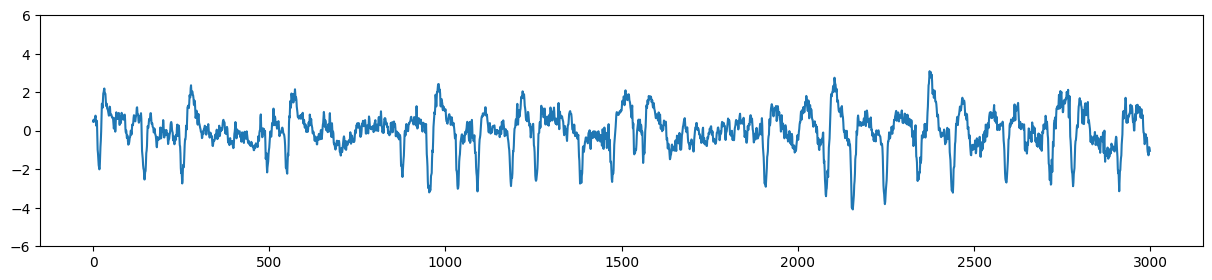

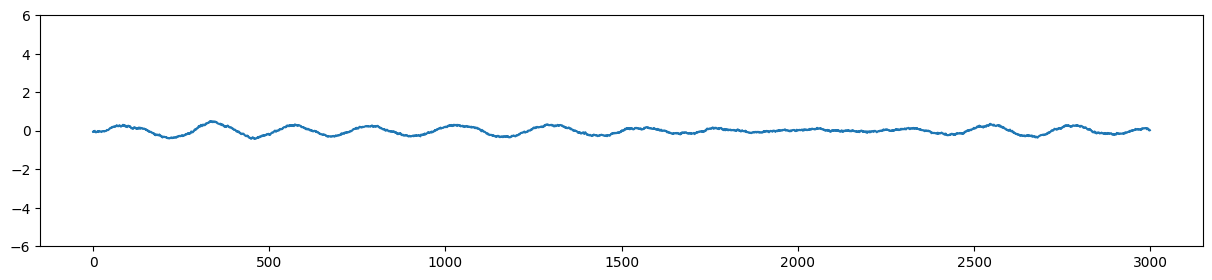

  0%|          | 0/501 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Awake
tensor([[[[-0.3727, -0.1854, -0.1373, -0.7242,  0.0151, -0.3546,  0.5295,
            0.0436,  0.3190, -0.0435,  0.3493, -0.2201,  0.8244, -0.8974,
           -0.1162, -0.8272]]],


        [[[-0.6750, -0.8273, -0.0698,  0.3650, -0.1564, -0.0442,  0.2360,
           -0.7588,  0.1877,  0.6475, -0.2566,  0.2874,  0.1284,  0.0440,
           -0.2968,  0.4906]]],


        [[[ 0.9656,  0.8267,  0.5957,  0.1385,  0.3506,  0.7730,  0.1154,
            0.3806, -0.6285, -0.9581,  0.7276, -0.2756, -0.9212, -0.6084,
           -0.0953,  0.7423]]],


        [[[ 0.8959, -0.2095, -0.0555,  0.6736, -0.8574,  0.5350, -0.8684,
           -0.7798, -0.9534,  0.3442,  0.8788,  0.9625, -0.2055, -0.6900,
            0.9971,  0.1972]]],


        [[[ 0.8537,  0.3980, -0.07

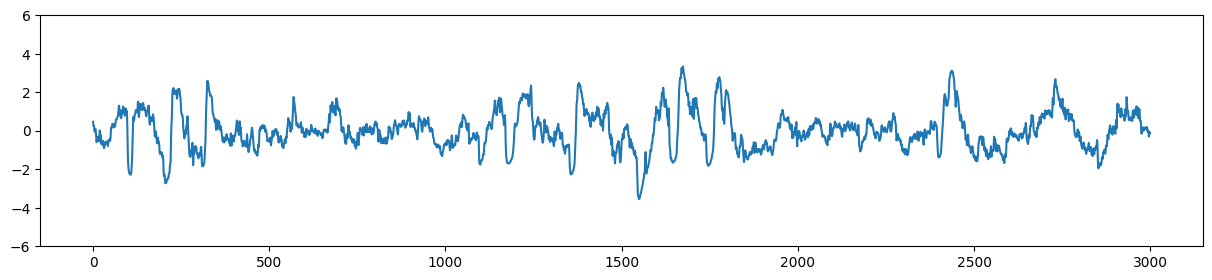

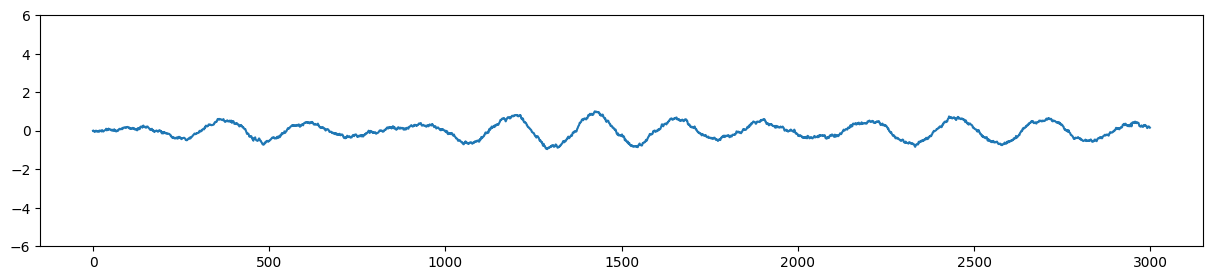

  0%|          | 0/501 [00:00<?, ?it/s]


In [7]:
ckp_path = "models/ae"

loader = PhysioLoader(
    #model_name=model,
    #loss_name=loss,
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    use_cache=True,
    sequence_lenght=seqlen,
    batch_size=batch_size,
)

for i in range(len(loader.checkpoints)):
    model, _, _, test_loader = loader.get_fold(i)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Imposta il modello in modalità di valutazione
    model = model.eval().to(device)

    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            indici = np.argwhere(labels.squeeze() == 0)
            indices_list = indici.tolist()[0]

            if(len(indices_list) > 7):
                print(indices_list)
                print(labels.squeeze())
                # Calcola le previsioni del modello
                index = indices_list[15]
                print(sleep_stages[labels[index].item()])

                input_hat = model(inputs.to(device))
                print(model.encode(inputs.to(device)))

                x2plot = inputs[index]
                x2plot = x2plot.squeeze().detach().cpu().numpy()
                plt.figure(figsize=(15, 3))
                plt.ylim(-6, 6)
                plt.plot(x2plot)
                plt.show()

                x_hat2plot = input_hat[index]
                x_hat2plot = x_hat2plot.squeeze().detach().cpu().numpy()
                plt.figure(figsize=(15, 3))
                plt.ylim(-6, 6)
                plt.plot(x_hat2plot)
                plt.show()
                break


## Extracting Loss Function Values


In [ ]:

import csv

def extract_column(csv_file, column_name):
    values = []
    steps = []
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row[column_name]:  # Check if the value in the specified column is not empty
                value = (round(float(row[column_name]), 3))
                epoch = int(row['epoch'])
                values.append((epoch, value))
    return values

# Example usage:
versions = [0,1,2,3,4,5,6,7,8,9]
column_name = 'val_loss_target'
model = 'binary_mod1_c8'
column_values_matrix = []
for ver in versions:
    csv_file = 'lightning_logs/' + model + '/version_'+ str(ver) +'/metrics.csv'
    column_values = extract_column(csv_file, column_name)
    print("(" + ")(".join([f"{epoch},{value}" for epoch, value in column_values]) + ")")
    column_values_matrix.append(column_values)

num_columns = len(column_values_matrix[0])
column_sums = [0] * num_columns
for row in column_values_matrix:
    for col_idx, (_, value) in enumerate(row):
        column_sums[col_idx] += value
column_means = [(constant[0], round(sum / len(column_values_matrix),3)) for constant, sum in zip(column_values_matrix[0][0:num_columns], column_sums)]

output = "(" + ")(".join([f"{epoch},{value}" for epoch, value in column_means]) + ")"
print("\n" +output)

(0,0.428)(1,0.347)(2,0.326)(3,0.337)(4,0.327)(5,0.335)(6,0.302)(7,0.32)(8,0.316)(9,0.335)(10,0.293)(11,0.324)(12,0.324)(13,0.318)(14,0.333)(15,0.316)(16,0.356)(17,0.376)(18,0.368)(19,0.395)
(0,0.266)(1,0.17)(2,0.166)(3,0.163)(4,0.156)(5,0.149)(6,0.153)(7,0.155)(8,0.156)(9,0.162)(10,0.163)(11,0.17)(12,0.209)(13,0.179)(14,0.234)(15,0.219)(16,0.193)(17,0.188)(18,0.22)(19,0.254)
(0,0.503)(1,0.372)(2,0.314)(3,0.314)(4,0.283)(5,0.261)(6,0.34)(7,0.286)(8,0.264)(9,0.254)(10,0.253)(11,0.335)(12,0.29)(13,0.308)(14,0.27)(15,0.294)(16,0.3)(17,0.311)(18,0.294)(19,0.3)
(0,0.319)(1,0.196)(2,0.174)(3,0.175)(4,0.172)(5,0.176)(6,0.178)(7,0.176)(8,0.179)(9,0.18)(10,0.177)(11,0.177)(12,0.181)(13,0.185)(14,0.201)(15,0.19)(16,0.208)(17,0.212)(18,0.24)(19,0.22)
(0,0.328)(1,0.179)(2,0.172)(3,0.183)(4,0.297)(5,0.18)(6,0.202)(7,0.206)(8,0.195)(9,0.218)(10,0.207)(11,0.202)(12,0.227)(13,0.215)(14,0.224)(15,0.231)(16,0.217)(17,0.282)(18,0.248)(19,0.218)
(0,0.27)(1,0.176)(2,0.168)(3,0.172)(4,0.171)(5,0.162)(6,0.169

In [ ]:
ckp_path = "models/ae"

loader = PhysioLoader(
    #model_name=model,
    #loss_name=loss,
    ckp_path=ckp_path,
    dataset_name=dataset["name"],
    version=dataset["version"],
    use_cache=True,
    sequence_lenght=seqlen,
    batch_size=batch_size,
)

acc = []
acc_concept = []

cm = []
cm_concept = []

reports = []
reports_concept = []

for i in range(len(loader.checkpoints)):
    model, _, _, test_loader = loader.get_fold(i)
    y_pred = []
    y_true = []
    act_pred = []
    act_true = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Imposta il modello in modalità di valutazione
    model = model.eval().to(device)

    outputs = []
    activations = []
    # Disabilita il calcolo del gradiente
    with torch.no_grad():
        # Aggiungi tqdm per mostrare il progresso
        
        for inputs, labels in tqdm(test_loader):
            # Calcola le previsioni del modello
            print(inputs.shape)
            break
            concepts, bo = model.encode(inputs.to(device))
            emb, act = concepts
            activations.extend(act.cpu().detach().squeeze())

            outputs.extend(model(inputs.to(device)).cpu().detach())
            y_true.extend(labels.cpu().detach())
            act_true.extend(labels.cpu().detach())

    outputs = torch.stack(outputs)
    activations = torch.stack(activations)

    y_true = torch.stack(y_true)
    act_true = torch.stack(act_true)

    y_pred = torch.argmax(outputs, dim=len(outputs.size()) - 1)
    act_pred = torch.argmax(activations, dim=len(activations.size()) - 1)

    if len(y_pred.size()) == 2:
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        act_pred = act_pred.reshape(-1)
        act_true = act_true.reshape(-1)

    y_true = y_true.numpy()
    act_true = act_true.numpy()
    y_pred = y_pred.numpy()
    act_pred = act_pred.numpy()

    #temp, finchè non ci sono le attivazioni vere
    if(model.n_classes == 2):
        #mette al posto di 2,3,4 il valore 1
        y_true[(y_true == 2) | (y_true == 3) | (y_true == 4)] = 1
        labels_idx = np.arange(2).astype(int)
    else:
        y_true = y_true
        
    print(y_true.shape, y_pred.shape, act_true.shape, act_pred.shape)

    acc.append(accuracy_score(y_true, y_pred))
    acc_concept.append(accuracy_score(act_true, act_pred))
    cm.append(confusion_matrix(y_true, y_pred, labels=labels_idx))
    cm_concept.append(confusion_matrix(act_true, act_pred, labels=labels_idx_concept))

    reports.append(classification_report(y_true, y_pred))
    reports_concept.append(classification_report(act_true, act_pred))

acc = np.array(acc)
cm = np.array(cm)

acc_concept = np.array(acc_concept)
cm_concept = np.array(cm_concept)

print(f"Accuracy: {acc.mean() * 100:.2f}% +/- {acc.std() * 100:.2f}%")
print(f"Accuracy concept: {acc_concept.mean() * 100:.2f}% +/- {acc_concept.std() * 100:.2f}%")

cm_mean = cm.mean(axis=0)
cm_mean = cm_mean.astype("float") / cm_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
#plt.figure(figsize=(3.5, 3))
sns.heatmap(
    cm_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    #xticklabels = ["Awake", "Sleep"],
    #yticklabels =  ["Awake", "Sleep"],
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Target Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

cm_concept_mean = cm_concept.mean(axis=0)
cm_concept_mean = cm_concept_mean.astype("float") / cm_concept_mean.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_concept_mean,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=sleep_stages,
    yticklabels=sleep_stages,
)
plt.title("Normalized Concept Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


